In [9]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import csv
import matplotlib.pyplot as plt

import sys
sys.path.append('../../PhasingFamilies')
sys.path.append('../../PhasingFamilies/phase')
from phase.input_output import PhaseData

In [10]:
dataset_name = 'ancestry'
#dataset_name = 'ssc.hg38'
data_dir = '../../DATA/%s' % dataset_name
phase_name = None
ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#ped_file = '../../DATA/ssc.hg38/ssc.ped'


#interval_chrom, interval_start_pos, interval_end_pos = '7', 4101620, 4747462
#interval_chrom, interval_start_pos, interval_end_pos = '19', 3604269, 3718439
interval_chrom, interval_start_pos, interval_end_pos = '19', None, None
crunch = False
num_trials = 1000
na = 2
flip = False

In [11]:
# pull phenotype data
sample_to_affected, sample_to_sex = dict(), dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		sample_to_sex[pieces[1]] = pieces[4]
		sample_to_sex[pieces[3]] = '2'
		sample_to_sex[pieces[2]] = '1'
		sample_to_affected[pieces[1]] = pieces[5]

In [12]:
phase_data = PhaseData(data_dir, phase_name)

sibpairs = phase_data.get_sibpairs()
print('sibpairs', len(sibpairs))

sibpairs 298


In [13]:
is_fully_phased = np.array([x['is_fully_phased'] for x in sibpairs])
is_identical = np.array([x['is_identical'] for x in sibpairs])
is_ibd_outlier = np.array([x['is_ibd_outlier'] for x in sibpairs], dtype=bool)
is_co_outlier = np.array([x['is_crossover_outlier'] for x in sibpairs], dtype=bool)

print('not fully phased', np.sum(~is_fully_phased))
print('identicals', np.sum(is_identical))
print('ibd outliers', np.sum(is_ibd_outlier))
print('crossover outliers', np.sum(is_co_outlier))

not fully phased 0
identicals 6
ibd outliers 0
crossover outliers 26


In [14]:
sibpairs = [x for x in phase_data.get_sibpairs() if x['is_fully_phased'] and \
                                                    not x['is_identical'] and \
                                                    not x['is_ibd_outlier'] and \
                                                    not x['is_crossover_outlier']]

family_chrom_to_cos = defaultdict(list)
for co in phase_data.get_crossovers():
    family_chrom_to_cos[(co['family'], co['chrom'])].append(co)

for gc in phase_data.get_crossovers():
    family_chrom_to_cos[(gc['family'], gc['chrom'])].append(gc)

print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
#print('num_affected', Counter([x['num_affected'] for x in sibpairs]))

for sibpair in sibpairs:
	sibpair['num_affected'] = int(sample_to_affected[sibpair['sibling1']]=='2') + int(sample_to_affected[sibpair['sibling2']]=='2')

if na == 3:
	sibpairs = [x for x in sibpairs if x['num_affected']>0]
else:
	sibpairs = [x for x in sibpairs if x['num_affected']==na]
num_sibpairs = len(sibpairs)


print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
#print('num_affected', Counter([x['num_affected'] for x in sibpairs]))


Overall
families 126
sibpairs 272
Overall
families 20
sibpairs 26


In [16]:
def parse_interval(x):
	return x.split(':')[0], int(x.split(':')[1].split('-')[0]), int(x.split(':')[1].split('-')[1])

def process_phase_file(sibpair):
    inds = phase_data.get_phase_info(sibpair['family'])['individuals']
    chroms, starts, ends, mat_phases, pat_phases, is_htss = phase_data.parse_phase_file_into_arrays(sibpair['family'])
    sib1_ind_index, sib2_ind_index = inds.index(sibpair['sibling1']), inds.index(sibpair['sibling2'])
       
    mat_match = (mat_phases[sib1_ind_index, :]==mat_phases[sib2_ind_index, :]).astype(int)
    mat_match[mat_match==0] = -1
    mat_match[mat_phases[sib1_ind_index, :]==-1] = 0
    mat_match[mat_phases[sib2_ind_index, :]==-1] = 0
    #mat_match[is_htss] = 0
        
    pat_match = (pat_phases[sib1_ind_index, :]==pat_phases[sib2_ind_index, :]).astype(int)
    pat_match[pat_match==0] = -1
    pat_match[pat_phases[sib1_ind_index, :]==-1] = 0
    pat_match[pat_phases[sib2_ind_index, :]==-1] = 0
    #pat_match[is_htss] = 0


    # we don't know what's going on inside crossovers
    for chrom in [str(x) for x in range(1, 23)]:
        is_in_chrom = np.array([c==chrom for c in chroms])
        for co in family_chrom_to_cos[(sibpair['family'], chrom)]:
            indices = is_in_chrom & (np.minimum(ends, co['end_pos'])-np.maximum(starts, co['start_pos']+1)>0)
        mat_match[indices] = 0
        pat_match[indices] = 0
        
    chrom_breaks = np.array([c1!=c2 for c1, c2 in zip(chroms[:-1], chroms[1:])])
    
    #print(len(chroms))
    #for p in zip(chroms, starts, ends, mat_match, pat_match):
    #    print(p)
                
    # collapse
    num_intervals = len(chroms)
    if num_intervals>1:
        change_index = np.where(chrom_breaks | (mat_match[:-1] != mat_match[1:]) | (pat_match[:-1] != pat_match[1:]))[0]
        chroms = [chroms[i] for i in np.hstack((change_index, num_intervals-1))]
        starts = starts[np.hstack(([0], change_index+1))]
        ends = ends[np.hstack((change_index, num_intervals-1))]
        mat_match = mat_match[np.hstack((change_index, num_intervals-1))]
        pat_match = pat_match[np.hstack((change_index, num_intervals-1))]
    
    #print(len(chroms))
    #for p in zip(chroms, starts, ends, mat_match, pat_match):
    #    print(p)
    #print(chroms, starts, ends)
    
    return chroms, starts, ends, mat_match, pat_match

In [17]:
# pull intervals
positions = set()
for sibpair in sibpairs:
    chroms, starts, ends, mat_match, pat_match = process_phase_file(sibpair)
    for chrom, start_pos, end_pos in zip(chroms, starts, ends):
        positions.add((chrom, start_pos))
        positions.add((chrom, end_pos))

positions = sorted(positions, key=lambda x: (int(x[0]), x[1]) if x[0].isdigit() else (23, x[1]))
chroms, interval_starts, interval_ends = [], [], []
prev_chrom, prev_pos = None, None
for c, p in positions:
	if prev_chrom is not None and prev_chrom == c:
		chroms.append(c)
		interval_starts.append(prev_pos)
		interval_ends.append(p)
	prev_chrom, prev_pos = c, p


interval_starts = np.array(interval_starts)
interval_ends = np.array(interval_ends)
num_intervals = len(interval_starts)
print('intervals', num_intervals)

intervals 5754


In [18]:
flip_match = {
    0: 0,
    1: -1,
    -1: 1
}

# sibpair, interval
is_mat_match = np.zeros((num_sibpairs, num_intervals), dtype=np.int8)
is_pat_match = np.zeros((num_sibpairs, num_intervals), dtype=np.int8)

interval_start_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_starts))])
interval_end_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_ends))])

for sibpair_index, sibpair in enumerate(sibpairs):
    for chrom, start_pos, end_pos, mat_match, pat_match in zip(*process_phase_file(sibpair)):
        start_index, end_index = interval_start_to_index[(chrom, start_pos)], interval_end_to_index[(chrom, end_pos)]+1
        is_mat_match[sibpair_index, start_index:end_index] = mat_match if (sibpair['num_affected']==0) or (sibpair['num_affected']==2) else flip_match[mat_match]
        is_pat_match[sibpair_index, start_index:end_index] = pat_match if (sibpair['num_affected']==0) or (sibpair['num_affected']==2) else flip_match[pat_match]


In [19]:
print(is_mat_match.shape)


(26, 5754)


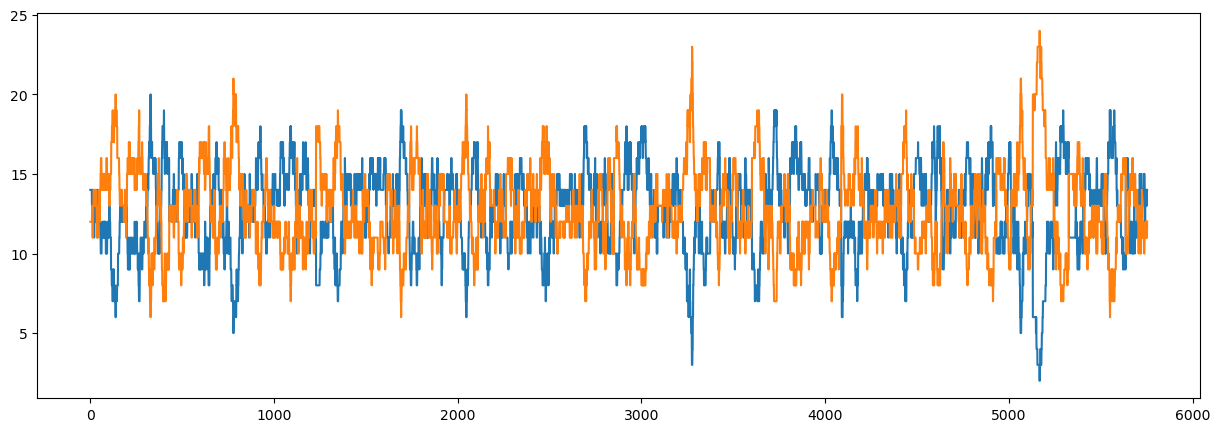

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(np.sum(is_mat_match==-1, axis=0))
#plt.plot(np.sum(is_mat_match==0, axis=0))
plt.plot(np.sum(is_mat_match==1, axis=0))
plt.show()

In [137]:
u = np.tile(np.arange(num_intervals), num_intervals)
v = np.repeat(np.arange(num_intervals), num_intervals)

indices = u >= v
x = u[indices]
y = v[indices]
num_intervals = len(x)

[  0   1   2 ... 194 195 195]
[  0   0   0 ... 194 194 195]


In [138]:
print(is_mat_match.shape, is_pat_match.shape)

# take into account sibling structure across quads
individuals = sorted(set([x['sibling1'] for x in sibpairs] + [x['sibling2'] for x in sibpairs]))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
sibling1_indices = np.array([ind_to_index[x['sibling1']] for x in sibpairs])
sibling2_indices = np.array([ind_to_index[x['sibling2']] for x in sibpairs])

A = np.random.randint(0, high=2, size=(num_trials+1, len(individuals), 2))
X1 = (A[:, sibling1_indices, 0] == A[:, sibling2_indices, 0]).astype(int)
X2 = (A[:, sibling1_indices, 1] == A[:, sibling2_indices, 1]).astype(int)

# randomly flip IBD in sibpairs
#X1 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))
#X2 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))

X1[X1==0] = -1
X2[X2==0] = -1

# first entry is actual IBD relationships
X1[0, :] = 1
X2[0, :] = 1

# now make X1 and X2 the IBD-phen relationships
is_discordant = np.array([sibpair['num_affected']==1 for sibpair in sibpairs])
X1[:, is_discordant] = -X1[:, is_discordant]
X2[:, is_discordant] = -X2[:, is_discordant]

print('ready')

if interval_chrom is not None:
	dataset_name += '.chr%s' % interval_chrom
if interval_start_pos is not None or interval_end_pos is not None:
	dataset_name += '.%d-%d' % (interval_start_pos, interval_end_pos)




(26, 196) (26, 196)
ready


In [139]:
## trial, interval, mat/pat
#rand_pvalue = -is_mat_match.shape[0] * np.ones((num_trials+1, num_intervals), dtype=int)
#
##print(na, 'mat')
##rand_pvalue[:, :, 0] = X1.dot(is_mat_match)
##print(na, 'pat')
##rand_pvalue[:, :, 1] = X2.dot(is_pat_match)
##print(na, 'both')
##rand_pvalue[:, :, 2] = rand_pvalue[:, :, 0]+rand_pvalue[:, :, 1]
#
#for j in range(num_sibpairs):
#    print(j, end=' ')
#    a = np.outer(X1[:, j], is_mat_match[j, :])
#    b = np.outer(X2[:, j], is_pat_match[j, :])
#    rand_pvalue[((a[:, x]>=0) & (b[:, y]>=0)) | ((a[:, y]>=0) & (b[:, x]>=0))] += 1
#    rand_pvalue[((a[:, x]==1) & (b[:, y]==1)) | ((a[:, y]==1) & (b[:, x]==1))] += 1
#    #rand_pvalue[(a==1) & (b==1)] += 1    

In [140]:
#plt.hist(rand_pvalue[0, :], bins=np.arange(-50, 50, 10), alpha=0.5, density=True)
#plt.hist(rand_pvalue[1:, :].flatten(), bins=np.arange(-50, 50, 10), alpha=0.5, density=True)
#plt.axvline(0, color='black')
#plt.show()

In [141]:
## -------------------- implementing Westfall-Young max T stepdown procedure
#
## indices are sorted along interval axis from interval with most IBD sharing
## to least IBD sharing
#final_pvalues = np.zeros((num_intervals, ))
#
#orig_indices = np.flip(np.argsort(rand_pvalue[0, :]), axis=0)
#
#max_t_k = np.zeros((num_trials+1, num_intervals+1))
#max_t_k[:, -1] = np.min(rand_pvalue, axis=1)
#for i, j in list(reversed(list(enumerate(orig_indices)))):
#	max_t_k[:, i] = np.maximum(max_t_k[:, i+1], rand_pvalue[:, j])
#max_t_k = max_t_k[:, :-1]
#
##max_t_k = np.flip(np.sort(rand_pvalue[:, :, is_mat], axis=1), axis=1)
#
#assert np.all(max_t_k[0, :] == rand_pvalue[0, orig_indices])
#
## calculate pi(j)
#pvalues = np.sum(max_t_k[1:, :] >= np.tile(max_t_k[0, :], (num_trials, 1)), axis=0)/num_trials
#pvalues = np.array([np.max(pvalues[:(i+1)]) for i in np.arange(pvalues.shape[0])])
#final_pvalues[orig_indices] = pvalues

In [149]:
print(is_mat_match.shape)
print(X1.shape)
print(np.tile(is_mat_match, (num_trials+1, 1, 1)).shape)
#mat = X1*np.tile(is_mat_match[:, x[interval_index]], (num_trials+1, 1))
#pat = X2*np.tile(is_pat_match[:, x[interval_index]], (num_trials+1, 1))
#y_mat = X1*np.tile(is_mat_match[:, y[interval_index]], (num_trials+1, 1))
#y_pat = X2*np.tile(is_pat_match[:, y[interval_index]], (num_trials+1, 1))


(26, 196)
(1001, 26)
(1001, 26, 196)


In [142]:

def calc_trial(trial_index):
    value = -num_sibpairs * np.ones((num_intervals,), dtype=int)
    for j in range(num_sibpairs):
        a = X1[trial_index, j]*is_mat_match[j, :]
        b = X2[trial_index, j]*is_pat_match[j, :]
        value[((a[x]>=0) & (b[y]>=0)) | ((a[y]>=0) & (b[x]>=0))] += 1
        value[((a[x]==1) & (b[y]==1)) | ((a[y]==1) & (b[x]==1))] += 1
    return value

def calc_interval(interval_index):
    x_mat = X1*np.tile(is_mat_match[:, x[interval_index]], (num_trials+1, 1))
    x_pat = X2*np.tile(is_pat_match[:, x[interval_index]], (num_trials+1, 1))
    y_mat = X1*np.tile(is_mat_match[:, y[interval_index]], (num_trials+1, 1))
    y_pat = X2*np.tile(is_pat_match[:, y[interval_index]], (num_trials+1, 1))
    
    return np.sum(((x_mat>=0) & (y_pat>=0)) | ((y_mat>=0) & (x_pat>=0)), axis=1) + \
           np.sum(((x_mat==1) & (y_pat==1)) | ((y_mat==1) & (x_pat==1)), axis=1) + \
           -num_sibpairs

#assert np.all(calc_trial(0)==rand_pvalue[0, :])
#assert np.all(calc_trial(27)==rand_pvalue[27, :])
#assert np.all(calc_trial(987)==rand_pvalue[987, :])
#
#assert np.all(calc_interval(0)==rand_pvalue[:, 0])
#assert np.all(calc_interval(27)==rand_pvalue[:, 27])
#assert np.all(calc_interval(987)==rand_pvalue[:, 987])

In [143]:
v = calc_trial(0)
orig_indices = np.argsort(v)
print('first trial complete')

print(list(reversed(list(enumerate(np.flip(orig_indices)))))[:5])
print(list(zip(np.arange(num_intervals-1, -1, -1), orig_indices, v[orig_indices]))[:5])


first trial complete
[(19305, 18445), (19304, 18362), (19303, 18361), (19302, 18360), (19301, 18316)]
[(19305, 18445, -24), (19304, 18362, -24), (19303, 18361, -24), (19302, 18360, -24), (19301, 18316, -24)]


In [144]:
print(num_intervals)

# -------------------- implementing low-mem Westfall-Young max T stepdown procedure

# indices are sorted along interval axis from interval with most IBD sharing
# to least IBD sharing
pvalues = np.ones((num_intervals,))
max_t_k = -num_sibpairs * np.ones((num_trials+1,), dtype=int)
q = np.zeros((num_intervals,), dtype=int)
for i, j in zip(np.arange(num_intervals-1, -1, -1), orig_indices):
    if (num_intervals-i)%1000==0:
        print(num_intervals-i, end=' ')
    max_t_k = np.maximum(max_t_k, calc_interval(j))
    q[i] = max_t_k[0]
    pvalues[i] = np.sum(max_t_k[1:] >= max_t_k[0])/num_trials
    

assert np.all(q == v[np.flip(orig_indices)])
pvalues = np.array([np.max(pvalues[:(i+1)]) for i in np.arange(num_intervals)])

final_pvalues_lowmem = np.zeros((num_intervals, ))
final_pvalues_lowmem[np.flip(orig_indices)] = pvalues

19306
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

In [145]:
#assert np.all(final_pvalues == final_pvalues_lowmem)

In [146]:
print(np.min(final_pvalues_lowmem, axis=0))


0.374


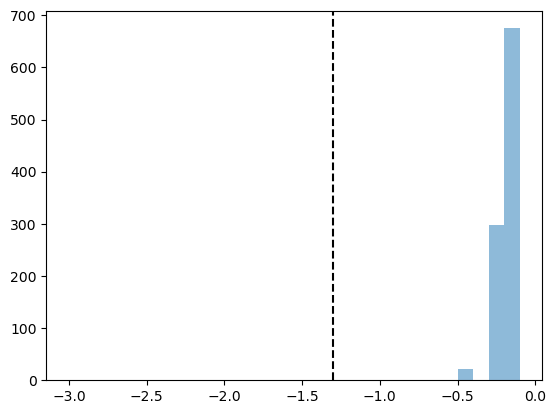

In [147]:
plt.hist(np.clip(np.log10(final_pvalues_lowmem), -3, None), alpha=0.5, bins=np.arange(-3, 0, 0.1))
plt.axvline(np.log10(0.05), color='black', linestyle='--')
plt.show()

In [105]:
for i in np.where(final_pvalues_lowmem<0.05)[0]:
    print(chroms[u[i]], interval_starts[u[i]], interval_ends[u[i]], 
         chroms[v[i]], interval_starts[v[i]], interval_ends[v[i]],)